In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
# Read the data
ames = pd.read_csv("AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [3]:
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900


In [4]:
# Model Library 
model_library = {}
records = []

# Normal Linear 

In [5]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1) #PID is an ID we shouldnt predict based on that
y = ames["SalePrice"]


# ct = ColumnTransformer(
#   [
#     ("dummify", 
#     OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If a dummy variable doesnt have a value you move on rather than throw a fir
#     make_column_selector(dtype_include=object)),
#     ("standardize", 
#     StandardScaler(), 
#     make_column_selector(dtype_include=np.number))
#   ],
#   remainder = "passthrough"
# )

# lr_pipeline = Pipeline(
#   [("preprocessing", ct),
#   ("linear_regression", LinearRegression())]
# )


# lr_pipeline_score = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'r2')
# model_library["linear_regression"] = lr_pipeline_score.mean()
# model_library

In [6]:
# Model Name
model_name = "All_Features"
regression_type = "Linear"  

# Preprocessing
ct = ColumnTransformer(
    [
        ("dummify", 
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=object)),
        ("standardize", 
         StandardScaler(), 
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("linear_regression", LinearRegression())
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.85389


# Ridge Practice

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with l=1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

In [7]:
# Model Name
model_name = "Ridge_1"
Alph = 1.0
regression_type = "Ridge"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge_regression", Ridge(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932


## Compare

Ridge regression produces a slightly better result across all matrics 

## Graph

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

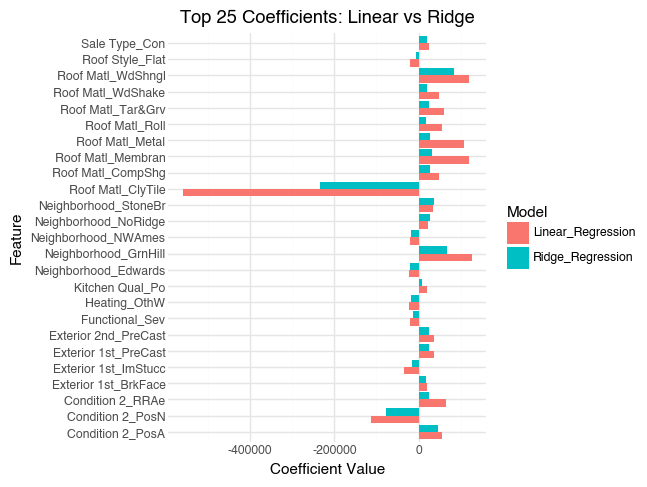

In [8]:
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
linear_coefs = model_library["All_Features"].named_steps['linear_regression'].coef_
ridge_coefs = model_library["Ridge_1"].named_steps['ridge_regression'].coef_

df_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Linear_Regression': linear_coefs,
    'Ridge_Regression': ridge_coefs
})

# Top 25 by absolute value 
df_coefs['Abs_Linear'] = df_coefs['Linear_Regression'].abs()
df_top = df_coefs.nlargest(25, 'Abs_Linear') 

# Reshape 
df_top_long = df_top.melt(
    id_vars='Feature', 
    value_vars=['Linear_Regression', 'Ridge_Regression'],
    var_name='Model', 
    value_name='Coefficient'
)

# Plot
coef_bar_plot = (
    p9.ggplot(df_top_long, p9.aes(x='Feature', y='Coefficient', fill='Model'))
    + p9.geom_col(position='dodge')
    + p9.coord_flip()
    + p9.labs(
        title='Top 25 Coefficients: Linear vs Ridge',
        x='Feature',
        y='Coefficient Value'
    )
    + p9.theme_minimal()
)

coef_bar_plot

Using the same pipeline as previously, perform tuning on lambda.

You should always try lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [9]:
# Model Name
model_name = "Ridge_0.001"
Alph = 0.001
regression_type = "Ridge"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge_regression", Ridge(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920


In [10]:
# Model Name
model_name = "Ridge_0.01"
Alph = 0.01
regression_type = "Ridge"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge_regression", Ridge(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186


In [11]:
# Model Name
model_name = "Ridge_0.1"
Alph = 0.1
regression_type = "Ridge"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge_regression", Ridge(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302


In [12]:
# Model Name
model_name = "Ridge_10"
Alph = 10
regression_type = "Ridge"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge_regression", Ridge(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272


# LASSO Practice 

Create a LASSO pipeline, and tune lambda. [0.001, 0.01, 0.1, 1, 10]

In [13]:
# Model Name
model_name = "Lasso_0.001"
Alph = 0.001
regression_type = "Lasso"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso_regression", Lasso(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e+11, tolerance: 1.793e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coor

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499


In [14]:
# Model Name
model_name = "Lasso_0.01"
Alph = 0.01
regression_type = "Lasso"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso_regression", Lasso(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.930e+11, tolerance: 1.793e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 1.348e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coor

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606


In [15]:
# Model Name
model_name = "Lasso_0.1"
Alph = 0.1
regression_type = "Lasso"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso_regression", Lasso(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e+11, tolerance: 1.793e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 1.348e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+11, tolerance: 1.474e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coor

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606
8,Lasso_0.1,Lasso,CV-5,29466.852082,9.114459e+08,0.856618


In [16]:
# Model Name
model_name = "Lasso_1"
Alph = 1
regression_type = "Lasso"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso_regression", Lasso(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09


,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606
8,Lasso_0.1,Lasso,CV-5,29466.852082,9.114459e+08,0.856618
9,Lasso_1,Lasso,CV-5,29408.532400,9.081603e+08,0.857152


In [17]:
# Model Name
model_name = "Lasso_10"
Alph = 10
regression_type = "Lasso"  

# Cross Validation Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso_regression", Lasso(alpha=Alph))
])

# Add to Library
model_library[model_name] = pipe.fit(X, y)

# Metrics Calculation 
rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = (pd.DataFrame(records))
cumulative_models

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606
8,Lasso_0.1,Lasso,CV-5,29466.852082,9.114459e+08,0.856618
9,Lasso_1,Lasso,CV-5,29408.532400,9.081603e+08,0.857152


In [18]:
# best_fitted = lasso10.fit(X, y)

## Graph 
Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS 

In [19]:
cumulative_models.sort_values('R2 Mean', ascending=False)

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
10,Lasso_10,Lasso,CV-5,29019.051919,8.865960e+08,0.860632
9,Lasso_1,Lasso,CV-5,29408.532400,9.081603e+08,0.857152
8,Lasso_0.1,Lasso,CV-5,29466.852082,9.114459e+08,0.856618
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920


Best Lasso model is Lasso_10

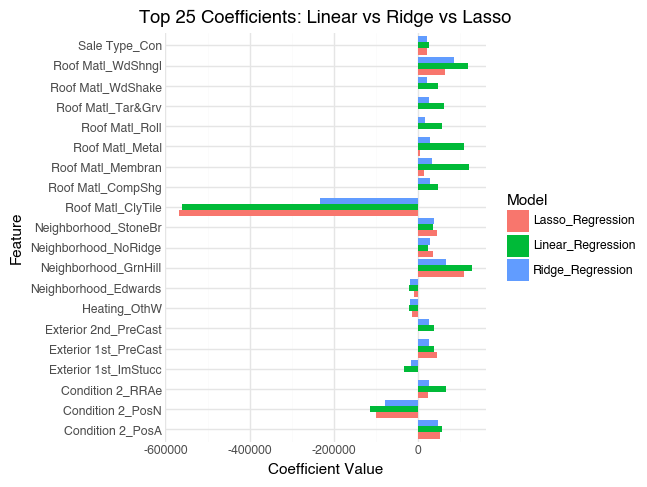

In [20]:
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
linear_coefs = model_library["All_Features"].named_steps['linear_regression'].coef_
ridge_coefs = model_library["Ridge_1"].named_steps['ridge_regression'].coef_
lasso_coefs = model_library["Lasso_10"].named_steps['lasso_regression'].coef_

df_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Linear_Regression': linear_coefs,
    'Ridge_Regression': ridge_coefs,
    'Lasso_Regression': lasso_coefs
})

# Top 20 by absolute value 
df_coefs['Abs_Linear'] = df_coefs['Linear_Regression'].abs()
df_top = df_coefs.nlargest(20, 'Abs_Linear') 

# Reshape 
df_top_long = df_top.melt(
    id_vars='Feature', 
    value_vars=['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression'],
    var_name='Model', 
    value_name='Coefficient'
)

# Plot
coef_bar_plot = (
    p9.ggplot(df_top_long, p9.aes(x='Feature', y='Coefficient', fill='Model'))
    + p9.geom_col(position='dodge')
    + p9.coord_flip()
    + p9.labs(
        title='Top 25 Coefficients: Linear vs Ridge vs Lasso',
        x='Feature',
        y='Coefficient Value'
    )
    + p9.theme_minimal()
)

coef_bar_plot

# Elastic Net

Create an Elastic Net pipeline, and tune lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

Keep same labdas as above [0.001, 0.01, 0.1, 1, 10] and choose randomly for alpha (the split between the two)

In [21]:
# Model Balancers
param_grid = {
    'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elasticnet_regression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("elasticnet_regression", ElasticNet())
])

# GridSearchCV
gscv = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error',
        'mse': 'neg_mean_squared_error'
    },
    refit='r2', 
    return_train_score=True
)

# Fit the grid search
gscv_fitted = gscv.fit(X, y)

# Extract results
cv_results = pd.DataFrame(gscv_fitted.cv_results_)

# Loop through each combination
for idx, row in cv_results.iterrows():
    alpha_val = row['param_elasticnet_regression__alpha']
    l1_ratio_val = row['param_elasticnet_regression__l1_ratio']
    
    model_name = f"ElasticNet_A_{alpha_val}&_L{l1_ratio_val}"
    regression_type = "ElasticNet"
    
    # Store in records
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Split": "CV-5",
        "RMSE Mean": -row['mean_test_rmse'],
        "MSE Mean": -row['mean_test_mse'],
        "R2 Mean": row['mean_test_r2']
    })

# Display
cumulative_models = pd.DataFrame(records)
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaco

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features,Linear,CV-5,29730.707208,9.275113e+08,0.853890
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
2,Ridge_0.001,Ridge,CV-5,29727.434694,9.273271e+08,0.853920
3,Ridge_0.01,Ridge,CV-5,29698.708547,9.257105e+08,0.854186
4,Ridge_0.1,Ridge,CV-5,29469.891972,9.128649e+08,0.856302
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
6,Lasso_0.001,Lasso,CV-5,29560.524210,9.180250e+08,0.855499
7,Lasso_0.01,Lasso,CV-5,29551.896187,9.173885e+08,0.855606
8,Lasso_0.1,Lasso,CV-5,29466.852082,9.114459e+08,0.856618
9,Lasso_1,Lasso,CV-5,29408.532400,9.081603e+08,0.857152


In [22]:
cumulative_models.sort_values('R2 Mean', ascending=False)

,Model,Regression Type,Split,RMSE Mean,MSE Mean,R2 Mean
5,Ridge_10,Ridge,CV-5,28633.512975,8.649009e+08,0.864272
18,ElasticNet_A_0.01&_L0.5,ElasticNet,CV-5,28632.337059,8.650612e+08,0.864268
17,ElasticNet_A_0.01&_L0.25,ElasticNet,CV-5,28647.530057,8.668958e+08,0.864059
19,ElasticNet_A_0.01&_L0.75,ElasticNet,CV-5,28661.286371,8.658125e+08,0.864051
16,ElasticNet_A_0.01&_L0.0,ElasticNet,CV-5,28681.290775,8.696757e+08,0.863687
11,ElasticNet_A_0.001&_L0.0,ElasticNet,CV-5,28747.690349,8.708609e+08,0.863192
12,ElasticNet_A_0.001&_L0.25,ElasticNet,CV-5,28784.529567,8.731883e+08,0.862813
13,ElasticNet_A_0.001&_L0.5,ElasticNet,CV-5,28849.377039,8.772350e+08,0.862155
1,Ridge_1,Ridge,CV-5,28871.919554,8.786063e+08,0.861932
24,ElasticNet_A_0.1&_L0.75,ElasticNet,CV-5,28963.561626,8.889149e+08,0.860881


The best model ended up being Ridge_10 but ElasticNet_A_0.01&_L0.5	was a very close second 